In [1]:
import pymc3 as pm
import theano
import theano.tensor as tt

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

%matplotlib inline

/usr/local/google/home/junpenglao/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Get data
n_seasons, n_TS, n_aliens, n_actions = 3, 3, 4, 3
n_trials, n_subj = 440, 31
alien_initial_Q = 0.12
# stimulus part 1
seasons = pd.read_csv("./1735_data/seasons.csv").values
# stimulus part 2
aliens = pd.read_csv("./1735_data/aliens.csv").values
# participants' selected actions
actions = pd.read_csv("./1735_data/actions.csv").values
# participants' received rewards
rewards = pd.read_csv("./1735_data/rewards.csv").values

trials, subj = np.meshgrid(range(n_trials), range(n_subj))
trials = trials.T
subj = subj.T

In [3]:
rewards

array([[ 0.3,  5.3,  1.5, ...,  7.8,  1.8,  1.7],
       [ 2.4,  0.9,  0.8, ...,  2.4,  2.4,  2.9],
       [ 2.3,  1.2,  1.2, ...,  0.7,  0.8,  3.6],
       ...,
       [ 1.6,  7.8,  4.3, ...,  5.1,  3.3,  0.4],
       [ 1.2,  0.6,  0.8, ..., 10.3,  0.9,  4. ],
       [ 1.2,  8.1,  1.6, ...,  5. ,  2.2,  1.3]])

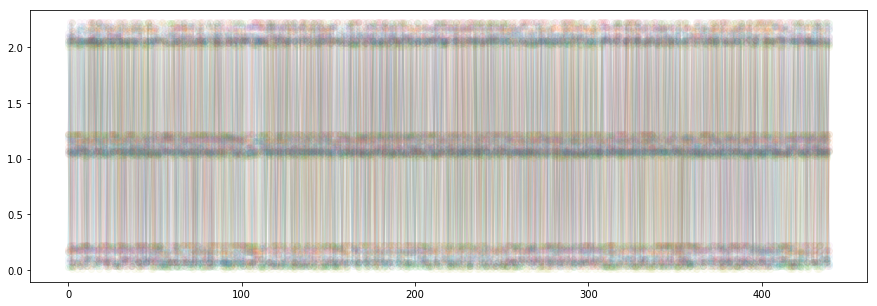

In [4]:
_, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(np.arange(actions.shape[0]), actions +
        np.random.rand(actions.shape[1])*.25, '-o', alpha=.05);

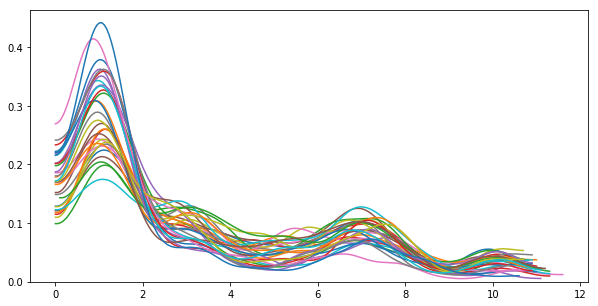

In [5]:
_, ax = plt.subplots(1, 1, figsize=(10, 5))
for isbj in range(rewards.shape[1]):
    pm.kdeplot(rewards[:, isbj], ax=ax);

In [6]:
rewards.min(), rewards.max()

(0.0, 11.6)

In [7]:
rewards.max(axis=0)

array([10.9, 11. , 11.1, 11. , 10.7, 10.7, 11.6, 10.9, 10.7, 11.3, 11. ,
       11. , 10.8, 11.3, 11.1, 11.1, 10.9, 10.8, 10.7, 10.9, 10.9, 10.9,
       11.3, 10.9, 10.9, 11.2, 10.6, 10.4, 10.7, 11.1, 10.6])

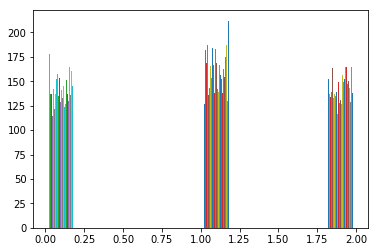

In [8]:
plt.hist(actions);

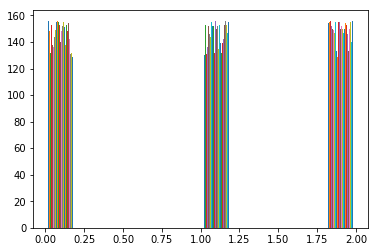

In [9]:
plt.hist(seasons);

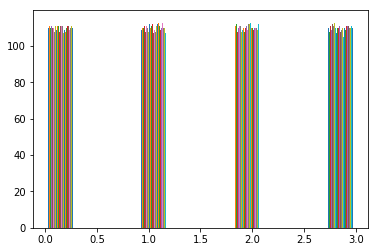

In [10]:
plt.hist(aliens);

In [11]:
iactions = actions[:, 0]
iseasons = seasons[:, 0]
ialiens = aliens[:, 0]
irewards = rewards[:, 0]

In [12]:
alpha = tt.scalar('alpha')
alpha.tag.test_value = .1
forgets = tt.scalar('forgets')
forgets.tag.test_value = .5
Qlow = tt.tensor3('Q')
Qlow.tag.test_value = np.random.randn(n_TS, n_aliens, n_actions)

def onestep(season, alien, action, reward, Qlow, _, alpha, forget):
    Qnew = (1 - forget) * Qlow + forget * alien_initial_Q
    RPE_low = reward - Qnew[season, alien, action]
    Qnew = tt.set_subtensor(Qnew[season, alien, action],
                            Qnew[season, alien, action] + alpha * RPE_low)
    return [Qnew, Qnew[season, alien, :]]


([x_vals, y_vals], updates) = theano.scan(fn=onestep,
                                          sequences=[theano.shared(iseasons),
                                                     theano.shared(ialiens),
                                                     theano.shared(iactions),
                                                     theano.shared(irewards)],
                                          outputs_info=[
                                              Qlow, tt.ones(n_actions)],
                                          non_sequences=[alpha, forgets],
                                          strict=True)

(x_vals[tt.arange(n_trials), iseasons, ialiens, :] - y_vals)

/usr/local/google/home/junpenglao/anaconda3/lib/python3.6/site-packages/theano/gpuarray/dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn("Your cuDNN version is more recent than "


Elemwise{sub,no_inplace}.0

In [13]:
RL_func = theano.function(inputs=[Qlow, alpha, forgets], outputs=[x_vals, y_vals], updates=updates)

In [14]:
[xtmp, ytmp] = RL_func(np.ones((n_TS, n_aliens, n_actions), dtype=np.float32), .1, .1)
(xtmp[np.arange(n_trials), iseasons, ialiens, :] - ytmp)

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       ...,
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [15]:
with pm.Model() as model:

    # RL parameters: softmax temperature beta; learning rate alpha; Q-value forgetting
    beta_mu = pm.Uniform('beta_mu', lower=0, upper=5, testval=1.25)
    beta_sd = pm.Uniform('beta_sd', lower=0, upper=5, testval=0.1)
    beta_matt = pm.Normal('beta_matt', mu=0, sd=1, shape=n_subj,
                          testval=np.random.choice([-0.1, 0, 0.1], n_subj))
    beta = pm.Deterministic('beta', beta_mu + beta_sd * beta_matt)

    alpha_mu = pm.Uniform('alpha_mu', lower=0, upper=1, testval=0.15)
    alpha_sd = pm.Uniform('alpha_sd', lower=0, upper=1, testval=0.05)
    alpha_matt = pm.Normal('alpha_matt', mu=0, sd=1, shape=n_subj,
                           testval=np.random.choice([-1, 0, 1], n_subj))
    alpha = pm.Deterministic('alpha', alpha_mu + alpha_sd * alpha_matt)

    forget_mu = pm.Uniform('forget_mu', lower=0, upper=1, testval=0.06)
    forget_sd = pm.Uniform('forget_sd', lower=0, upper=1, testval=0.03)
    forget_matt = pm.Normal('forget_matt', mu=0, sd=1, shape=n_subj,
                            testval=np.random.choice([-1, 0, 1], n_subj))
    forget = pm.Deterministic('forget', forget_mu + forget_sd * forget_matt)

    # Get the right shapes
    betas = tt.tile(tt.repeat(beta, n_actions), n_trials).reshape(
        [n_trials, n_subj, n_actions])    # Q_sub.shape
    forgets = tt.repeat(forget, n_TS * n_aliens * n_actions).reshape(
        [n_subj, n_TS, n_aliens, n_actions])  # Q_low for 1 trial
    # Initialize Q-values
    Q_low0 = alien_initial_Q * tt.ones([n_subj, n_TS, n_aliens, n_actions])

    # Update Q-values based on stimulus, action, and reward
    def update_Qs(season, alien, action, reward, Q_low, _, alpha, forget, n_subj):
        # Loop over trials: take data for all subjects, 1 single trial

        # Forget Q-values a little bit in each trial
        Q_low_new = (1 - forget) * Q_low + forget * alien_initial_Q

        # Calculate RPE & update Q-values
        RPE_low = reward - Q_low_new[tt.arange(n_subj), season, alien, action]
        Q_low_new = tt.set_subtensor(Q_low_new[tt.arange(n_subj), season, alien, action],
                                     Q_low_new[tt.arange(n_subj), season, alien, action]
                                     + alpha * RPE_low)

        return [Q_low_new, Q_low_new[tt.arange(n_subj), season, alien, :]]

    # Get Q-values for the whole task (update Q-values in each trial)
    (_, Q_low), _ = theano.scan(fn=update_Qs,
                                sequences=[theano.shared(seasons),
                                           theano.shared(aliens),
                                           theano.shared(actions),
                                           theano.shared(rewards)],
                                outputs_info=[Q_low0, tt.ones(
                                    [n_subj, n_actions])],
                                non_sequences=[alpha, forgets, n_subj],
                                strict=True)

    # Add first trial's Q-values, remove last trials Q-values
    Q_sub = tt.concatenate([[Q_low0[tt.arange(n_subj), seasons[0], aliens[0], :]],
                            Q_low[:-1]],
                           axis=0)

    # First step to translate into probabilities: apply exp
    p = tt.exp(betas * Q_sub)

    # Bring p in the correct shape for pm.Categorical: 2-d array of trials
    action_wise_p = p.reshape([n_trials * n_subj, n_actions])
    action_wise_actions = actions.flatten()

    # Select actions (& second step of calculating probabilities: normalize)
    observed = pm.Categorical('obs', p=action_wise_p,
                             observed=action_wise_actions)

In [ ]:
with model:
    trace = pm.sample(1000, tune=1000, chains=4, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [forget_matt, forget_sd, forget_mu, alpha_matt, alpha_sd, alpha_mu, beta_matt, beta_sd, beta_mu]
 24%|██▍       | 485/2000 [6:50:20<21:21:46, 50.76s/it]

In [11]:
zrewards = (rewards - rewards.mean(axis=0, keepdims=True))/rewards.std(axis=0, keepdims=True)

In [56]:
with pm.Model() as m:
    # RL parameters: softmax temperature beta; learning rate alpha; Q-value forgetting
    beta_mu = pm.Normal('beta_mu', 0., 1.)
    beta = pm.Normal('beta',
                     mu=beta_mu,
                     sd=1,
                     shape=(1, n_subj, n_actions))
    betas = tt.tile(beta, (n_trials, 1, 1))

#     alpha_mu = pm.Beta('alpha_mu', alpha=1., beta=1.)
#     alpha_sd = pm.Uniform('alpha_sd',
#                           lower=0,
#                           upper=tt.sqrt(alpha_mu*(1-alpha_mu)))
#     alpha = pm.Beta('alpha', mu=alpha_mu, sd=alpha_sd, shape=n_subj)
    alpha = pm.Normal('alpha', mu=0, sd=1, shape=n_subj)

    forget_mu = pm.Beta('forget_mu', alpha=1., beta=1.,
                        shape=(n_subj, 1, 1, 1))
    forget_sd = pm.Uniform('forget_sd',
                           lower=0,
                           upper=tt.sqrt(forget_mu*(1-forget_mu)),
                           shape=(n_subj, 1, 1, 1))
    forgets = pm.Beta('forgets',
                      mu=forget_mu,
                      sd=forget_sd,
                      shape=(n_subj, n_TS, n_aliens, n_actions))

    # Initialize Q-values
    Q_low0 = alien_initial_Q * tt.ones([n_subj, n_TS, n_aliens, n_actions])

    # Update Q-values based on stimulus, action, and reward
    def update_Qs(season, alien, action, reward, Q_low, _, alpha, forget, n_subj):
        # Loop over trials: take data for all subjects, 1 single trial

        # Forget Q-values a little bit in each trial
        Q_low_new = (1 - forget) * Q_low + forget * alien_initial_Q

        # Calculate RPE & update Q-values
        RPE_low = reward - Q_low_new[tt.arange(n_subj), season, alien, action]
        Q_low_new = tt.set_subtensor(Q_low_new[tt.arange(n_subj), season, alien, action],
                                     Q_low_new[tt.arange(n_subj), season, alien, action]
                                     + alpha * RPE_low)

        return [Q_low_new, Q_low_new[tt.arange(n_subj), season, alien, :]]

    # Get Q-values for the whole task (update Q-values in each trial)
    (_, Q_low), _ = theano.scan(fn=update_Qs,
                                sequences=[theano.shared(seasons),
                                           theano.shared(aliens),
                                           theano.shared(actions),
                                           theano.shared(zrewards)],
                                outputs_info=[Q_low0, tt.ones(
                                    [n_subj, n_actions])],
                                non_sequences=[alpha, forgets, n_subj],
                                strict=True)

    # Add first trial's Q-values, remove last trials Q-values
    Q_sub = tt.concatenate([[Q_low0[tt.arange(n_subj), seasons[0], aliens[0], :]],
                            Q_low[:-1]],
                           axis=0)

    # First step to translate into probabilities: apply exp
#     p = tt.exp(betas * Q_sub)
    p = (betas * Q_sub).reshape([n_trials * n_subj, n_actions])

    # Bring p in the correct shape for pm.Categorical: 2-d array of trials
    action_wise_p = tt.nnet.softmax(p)
    action_wise_actions = actions.flatten()

    # Select actions (& second step of calculating probabilities: normalize)
    observed = pm.Categorical('obs',
                              p=action_wise_p,
                              observed=action_wise_actions)

    trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [forgets, forget_sd, forget_mu, alpha, beta, beta_mu]
Sampling 2 chains: 100%|██████████| 4000/4000 [5:16:08<00:00,  9.16s/draws]   
There were 996 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.08752539925005927, but should be close to 0.8. Try to increase the number of tuning steps.
There were 995 divergences after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


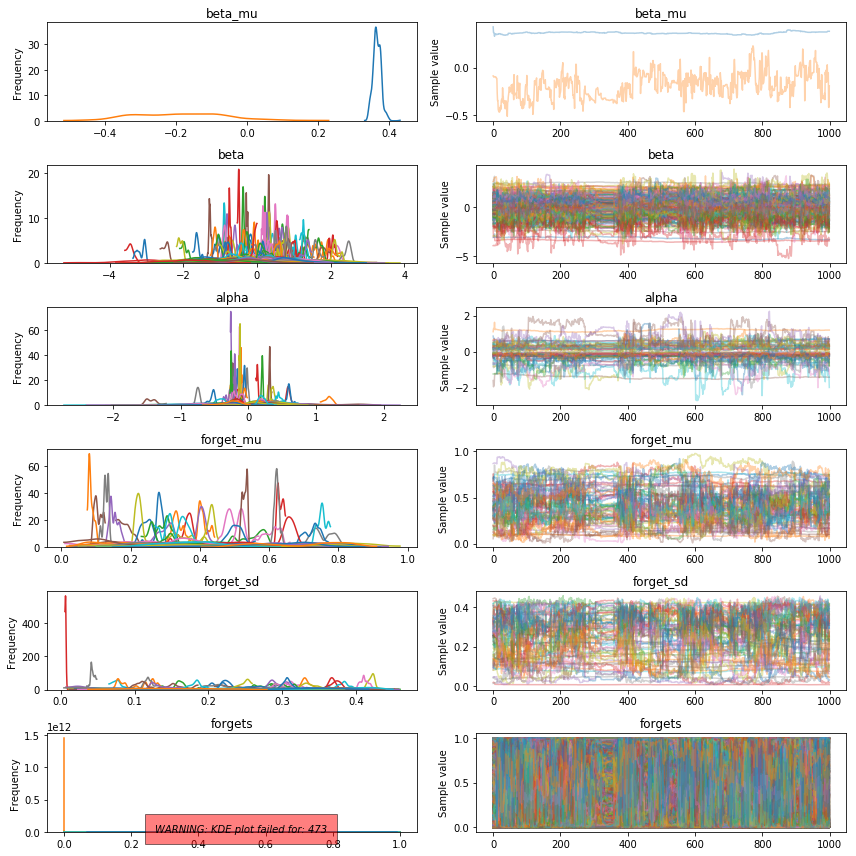

In [57]:
pm.traceplot(trace);